In [164]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
from scipy.stats import norm
from collections import Counter
import matplotlib.pyplot as plt

### Calculate (future) ACE from forecasts of a single intensity model using cyclone a-tracks
### Uses linear interpolation to get values of 6h intervals

# download latest a-tracks manually for basin of interest (no automation yet)
# and change names of atrack files below

# note: make sure to gunzip them
# https://ftp.nhc.noaa.gov/atcf/aid_public/?C=M;O=D
    
### DOWNLOAD LATEST ATRACKS AND UPDATE THE FOLLOWING TWO VARIABLES EVERY RUN OF THE NOTEBOOK
atrack_files = [
    #'aal052024.dat'
]

# latest real time ACE (for North Atlantic)
# from http://tropical.atmos.colostate.edu/Realtime/
# Updated 21 MT (+6=03 UTC)
real_time_ACE = 55.1
#selected_storm_id = "AL5"
#selected_storm_ace = 6.7

#### specify end of real time ACE (UTC), or the latest time of which there would be expected no TC genesis
#### this will be adjusted to last forecast valid time if there are atracks
ace_time_end_str = "2024-09-07 12:00:00"
ace_time = datetime.fromisoformat(ace_time_end_str)

#min_year = 1851
min_year = 1966

# Note: this auto-tunes an expotential decay parameter for expected ACE using MSE.
# Make sure to:
#   1) Check the difference of MSE in the validation
#   2) Check to make sure that the "Rate final tuning" is within the bounds of the rates tried

# Update: Oct 22: Since the last few days the exponential decay validates poorly and is no longer robust
#   Will use second predictor even though it has only 16 samples

In [165]:
##### CONFIG BASIN AND INTENSITY MODEL
match_basin = 'AL'
# consensus model
match_model = 'IVCN'

In [166]:
ab_column_names = [
    'BASIN',
    'CY',
    'YYYYMMDDHH',
    'TECHNUM/MIN',
    'TECH',
    'TAU',
    'LatN/S',
    'LonE/W',
    'VMAX',
    'MSLP',
    'TY',
    'RAD',
    'WINDCODE',
    'RAD1',
    'RAD2',
    'RAD3',
    'RAD4',
    'POUTER',
    'ROUTER',
    'RMW',
    'GUSTS',
    'EYE',
    'SUBREGION',
    'MAXSEAS',
    'INITIALS',
    'DIR',
    'SPEED',
    'STORMNAME',
    'DEPTH',
    'SEAS',
    'SEASCODE',
    'SEAS1',
    'SEAS2',
    'SEAS3',
    'SEAS4',
    'USERDEFINED1',
    'userdata1',
    'USERDEFINED2',
    'userdata2',
    'USERDEFINED3',
    'userdata3',
    'USERDEFINED4',
    'userdata4',
    'USERDEFINED5',
    'userdata5'
]

In [167]:
track_line_lists = []

# read the tracks
for atrack_file in atrack_files:
    with open(atrack_file, 'r') as file:
        lines = file.readlines()
    for line in lines:
        line_list = line.split(',')
        line_list_trim = [x.strip() for x in line_list]
        line_list_trim_rempty = line_list_trim
        
        # trim empty columns on right
        # a tracks have an extra comma before EOL for some reason (should have max 45 columns)
        line_list_trim_rempty.reverse()
        line_list_trim_empty = []
        for [i, v] in enumerate(line_list_trim_rempty):
            if v:
                line_list_trim_empty = line_list_trim_rempty[i:]
                break
        line_list_trim_empty.reverse()
        # convert init time strings to timestamp format
        line_list_trim_empty[2] = datetime.strptime(line_list_trim_empty[2], '%Y%m%d%H')
            
        track_line_lists.append(line_list_trim_empty)

In [168]:
# convert the line lists to a dataframe
df = pd.DataFrame(track_line_lists, columns=ab_column_names)

In [169]:
# get the last matching forecasts
df_match = df.loc[(df['BASIN'] == match_basin) & (df['TECH'] == match_model)]

newest_matching_cyclone_forecast_dfs = []
for cyclone_num in df_match['CY'].unique():
    df_cyclone = df_match.loc[(df['CY'] == cyclone_num)]
    newest_init_time = df_cyclone['YYYYMMDDHH'].max()
    newest_forecast = df_cyclone.loc[(df['YYYYMMDDHH'] == newest_init_time)]
    # make sure these columns are numeric
    # convert to numeric
    col_numeric_names = ["CY", "TAU", "VMAX", "MSLP"]
    for col_numeric_name in col_numeric_names:
        newest_forecast = newest_forecast.astype({col_numeric_name:'int'})
    # append to list of cyclone forecast dfs
    newest_matching_cyclone_forecast_dfs.append(newest_forecast)

In [170]:
# interpolate to provide 06 taus
interp_intensity_cyclone_dfs = []

last_valid_time = None

for cyclone_df in newest_matching_cyclone_forecast_dfs:
    forecast_taus = cyclone_df['TAU'].unique()
    min_tau = forecast_taus.min()
    max_tau = forecast_taus.max()
    taus_6h = list(range(min_tau, max_tau + 6, 6))
    taus_missing = []
    for tau in taus_6h:
        if tau not in forecast_taus:
            taus_missing.append(tau)
    for missing_tau in taus_missing:
        # get prev tau
        prev_tau = missing_tau
        while prev_tau >= min_tau:
            prev_tau = prev_tau - 1
            if prev_tau in forecast_taus:
                break
        next_tau = missing_tau
        while next_tau <= max_tau:
            next_tau = next_tau + 1
            if next_tau in forecast_taus:
                break
        prev_intensity = cyclone_df.loc[(cyclone_df['TAU'] == prev_tau)]['VMAX'].values[0]
        next_intensity = cyclone_df.loc[(cyclone_df['TAU'] == next_tau)]['VMAX'].values[0]
        interpolated_intensity = int(round((prev_intensity + next_intensity) / 2.0))
        cyclone_df = cyclone_df.reset_index(drop=True)
        prev_idx = cyclone_df.loc[(cyclone_df['TAU'] == prev_tau)].index.values[0]
        # copy row
        interp_row = cyclone_df.iloc[prev_idx].copy()
        # only manipulate the TAU and INTENSITY so we don't have to copy the rest of the values
        # the long/lat and rest of data have not been interpolated....
        interp_row['TAU'] = missing_tau
        interp_row['VMAX'] = interpolated_intensity
        # add row
        #cyclone_df = cyclone_df.append(interp_row, ignore_index=True)
        cyclone_df = pd.concat([cyclone_df, pd.DataFrame([interp_row])], ignore_index=True)
    cyclone_df = cyclone_df.reset_index(drop=True)
    cyclone_df.sort_values(by=['TAU'], inplace=True)
    cyclone_df = cyclone_df.reset_index(drop=True)
    interp_intensity_cyclone_dfs.append(cyclone_df)
    # cyclone number
    cyclone_num = cyclone_df['CY'].iloc[-1]
    basin = cyclone_df.iloc[-1]['BASIN']
    init_time = cyclone_df.iloc[0]['YYYYMMDDHH']
    min_tau_time = init_time + timedelta(hours=int(min_tau))
    valid_time = init_time + timedelta(hours=int(max_tau))
    # print the forecast times
    print(f"{basin}{cyclone_num}: {min_tau}-{max_tau}H : {min_tau_time} to {valid_time}")
    if last_valid_time == None:
        last_valid_time = valid_time
    if valid_time > last_valid_time:
        last_valid_time = valid_time

print("")
print("Longest forecast covers up until:", last_valid_time)


Longest forecast covers up until: None


In [171]:
# exclude storms less than 35 kt
# exclude forecasts at 00h (since this may already be included in real time ACE)
ACE_min_kt = 35
storm_intensities_above_min = {}
for cyclone_df in interp_intensity_cyclone_dfs:
    cyclone_num = cyclone_df['CY'].iloc[-1]
    basin = cyclone_df.iloc[-1]['BASIN']
    storm_name_str = f'{basin}{cyclone_num}'
    min_kt_rows = cyclone_df.loc[(cyclone_df['VMAX'] >= ACE_min_kt) & (cyclone_df['TAU'] > 0)]['VMAX']
    storm_intensities_above_min[storm_name_str] = list(min_kt_rows.values)

In [172]:
forecasts_ace = {}
for [storm_name, vmax] in storm_intensities_above_min.items():
    forecast_storm_ace = (pow(10, -4) * np.sum(np.power(vmax, 2)))
    forecasts_ace[storm_name] = round(forecast_storm_ace,2)

In [173]:
forecast_total_ace = 0
print(f"Future contributions (up until {last_valid_time}) of cyclone ACE values in {match_basin} basin (including INVESTs)\n",
      f"   from latest forecast using {match_model} (excluding 00h) by interpolating intensities")
for [storm_name, ace] in forecasts_ace.items():
    print(f"  ACE(future) for {storm_name} = {ace}")
    if storm_name == selected_storm_id:
        forecast_selected_storm_ace = selected_storm_ace + ace
    forecast_total_ace += ace
print(f"  Total ACE(future): {forecast_total_ace:4.2f}")
total_ace_until_forecast = real_time_ACE + forecast_total_ace
print("")
print("Real-time ACE:", real_time_ACE)
print(f"Total ACE (real-time + forecast) up until {last_valid_time}: {total_ace_until_forecast:.2f}")

Future contributions (up until None) of cyclone ACE values in AL basin (including INVESTs)
    from latest forecast using IVCN (excluding 00h) by interpolating intensities
  Total ACE(future): 0.00

Real-time ACE: 55.1
Total ACE (real-time + forecast) up until None: 55.10


In [174]:
print(storm_intensities_above_min)

{}


In [175]:
print(interp_intensity_cyclone_dfs)

[]


In [176]:

# Define a function to convert the components into datetime objects
def convert_to_datetime(components, debug = False):
    # only use first time
    try:
        c = "".join(components.astype(str))
        year = int(c[0:4])
        month = int(c[5:7])
        day = int(c[8:10])
        hour = int(c[11:13])
        minute = int(c[14:16])
        second = int(c[17:])
        dt = datetime(year, month, day, hour, minute, second)
        return dt
    except:
        if debug:
            print("err")
            print(components)
        return None
    
def extract_first_num(components):
    try:
        return components[0].astype(int)
    except:
        return None

def extract_first_str(components):
    try:
        return "".join(components[0].astype(str))
    except:
        return None

def extract_first_byte(components):
    try:
        return "".join(components[0].astype(str))
    except:
        return None

In [177]:
# Calculate historical ACE energies from best tracks and use this to calculate expected ACE values from the above values

# from https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r00/access/csv/
best_tracks_csv = 'ibtracs.NA.list.v04r00.csv'

# Read the CSV file into a DataFrame without automatically assigning column names
df = pd.read_csv(best_tracks_csv, header=0, skiprows=[1], low_memory=False)


In [178]:
# Create a dictionary that specifies the data types for each column
dtype_mapping = {
    'LAT': float,
    'LON': float,
    'WMO_WIND': float,
    'WMO_PRES': float,
    'USA_WIND': float,
    'DIST2LAND': float,
    'LANDFALL': float,
    'STORM_SPEED': float,
    'STORM_DIR': float
}

# Apply dtype conversion to specific columns, treating non-numeric values as NaN
for column, data_type in dtype_mapping.items():
    df[column] = pd.to_numeric(df[column], errors='coerce').astype(data_type)

# convert time to datetime
df['ISO_TIME'] = pd.to_datetime(df['ISO_TIME'])


In [179]:
pd.set_option('display.max_rows', 10)
# Create a mask to filter the rows for only 6 hour times
# Also only include years from min_year
mask = (df['ISO_TIME'].dt.year >= min_year) & (df['ISO_TIME'].dt.hour.isin([0, 6, 12, 18])) & (df['ISO_TIME'].dt.minute == 0) & (df['ISO_TIME'].dt.second == 0)

# Apply the mask to filter the DataFrame
filtered_df = df[mask].copy()

# drop all but relevant column's for speed
selected_columns = ['SEASON', 'ISO_TIME', 'WMO_WIND', 'USA_WIND', 'NATURE', 'NAME', 'USA_STATUS', 'BASIN', 'USA_ATCF_ID']
filtered_df = filtered_df[selected_columns]

In [180]:
# exclude storms that cross basins by only including null basins (AL basin is a string 'NA' converted to NaN)
df_min_35kt = filtered_df.loc[(filtered_df['USA_WIND'] >= 35) & (filtered_df['USA_STATUS'].isin(['TS', 'SS', 'HU', 'HR'])) & (filtered_df['BASIN'].isnull())]
# filter out storms out of season
#df_min_35kt = df_min_35kt[(df_min_35kt['ISO_TIME'].dt.month >= 6) & (df_min_35kt['ISO_TIME'].dt.month <= 11)]
df_min_35kt.reset_index()

,index,SEASON,ISO_TIME,WMO_WIND,USA_WIND,NATURE,NAME,USA_STATUS,BASIN,USA_ATCF_ID
0,73915,1966,1966-06-06 00:00:00,35.0,35.0,TS,ALMA,TS,NaN,AL011966
1,73917,1966,1966-06-06 06:00:00,40.0,40.0,TS,ALMA,TS,NaN,AL011966
2,73919,1966,1966-06-06 12:00:00,50.0,50.0,TS,ALMA,TS,NaN,AL011966
3,73921,1966,1966-06-06 18:00:00,65.0,65.0,TS,ALMA,HU,NaN,AL011966
4,73923,1966,1966-06-07 00:00:00,65.0,65.0,TS,ALMA,HU,NaN,AL011966
...,...,...,...,...,...,...,...,...,...,...
14207,126916,2023,2023-10-27 18:00:00,NaN,55.0,TS,TAMMY,TS,NaN,AL202023
14208,126918,2023,2023-10-28 00:00:00,NaN,50.0,TS,TAMMY,TS,NaN,AL202023
14209,126920,2023,2023-10-28 06:00:00,NaN,45.0,TS,TAMMY,TS,NaN,AL202023
14210,126922,2023,2023-10-28 12:00:00,NaN,45.0,TS,TAMMY,TS,NaN,AL202023


In [181]:
len(df.loc[(df['BASIN'].isnull())])

126392

In [182]:
df['BASIN']

0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
         ... 
126965    NaN
126966    NaN
126967    NaN
126968    NaN
126969    NaN
Name: BASIN, Length: 126970, dtype: object

In [183]:
#use the last valid_time if there is an a-track forecast
if atrack_files:
    ace_time = last_valid_time

# Calculate ACE for up to ace_time_end_str for all years

ace_time_month = ace_time.month
ace_time_day = ace_time.day

season_ace = {}
season_kt = {}
kt_at_time = {}
season_ace_to_time_end = {}
season_ace_above_real_time = {}

for idx in range(0, len(df_min_35kt)):
    r = df_min_35kt.iloc[idx]
    t = r['ISO_TIME']
    #w = r['WMO_WIND']
    w = r['USA_WIND']
    kt_at_time[t] = w

years = list(set(list(df_min_35kt['SEASON'].values)))

ace_by_atcf_id = {}

for season in years:
    df_season_min_35kt = df_min_35kt.loc[(df_min_35kt['SEASON'] == season)]
    #kts = list(df_season_min_35kt['WMO_WIND'].values)
    kts = list(df_season_min_35kt['USA_WIND'].values)
    season_kt[season] = kts
    season_atcf_ids = sorted(list(set(df_season_min_35kt['USA_ATCF_ID'].values)))
    for atcf_id in season_atcf_ids:
        df_atcf = df_season_min_35kt.loc[(df_season_min_35kt['USA_ATCF_ID'] == atcf_id)]
        atcf_kts = list(df_atcf['USA_WIND'].values)
        atcf_ace = (pow(10, -4) * np.sum(np.power(atcf_kts, 2)))
        ace_by_atcf_id[atcf_id] = atcf_ace
    ace = (pow(10, -4) * np.sum(np.power(kts, 2)))
    season_ace[season] = ace
    
    # exclude ace that are not representative for population statistics when they are below real time ACE
    if ace >= real_time_ACE:
        season_ace_above_real_time[season] = ace
    
    # calculate ACE until ace_time_end_str for each year
    df_season_to_time_end_min_35kt = df_season_min_35kt.loc[
        (df_season_min_35kt['ISO_TIME'].dt.month < ace_time_month) | 
        (
            (df_season_min_35kt['ISO_TIME'].dt.month == ace_time_month) &
            (df_season_min_35kt['ISO_TIME'].dt.day <= ace_time_day)
        )
    ]
    #kts = list(df_season_to_time_end_min_35kt['WMO_WIND'].values)
    kts = list(df_season_to_time_end_min_35kt['USA_WIND'].values)
    ace = (pow(10, -4) * np.sum(np.power(kts, 2)))
    season_ace_to_time_end[season] = ace

print(f"Done calculating ACE for each year up until {ace_time.month}/{ace_time.day}")

Done calculating ACE for each year up until 9/7


In [184]:
season_ace[2006]

78.53500000000001

Number of storms in AL basin with ACE > 35.1 (since 1966): 30
Years with storms in AL basin having ACE > 35.1 (since 1966): [1966, 1967, 1971, 1979, 1980, 1989, 1995, 1996, 1998, 1999, 2000, 2003, 2004, 2005, 2007, 2008, 2010, 2016, 2017, 2018, 2019, 2021, 2023]
% of years having storms in AL basin having ACE > 35.1 (since 1966): 51.7 %


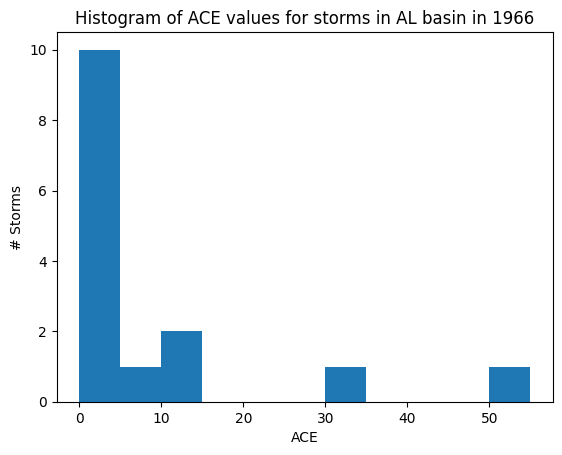

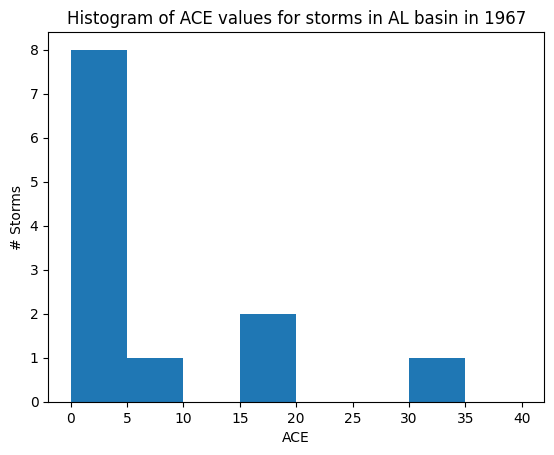

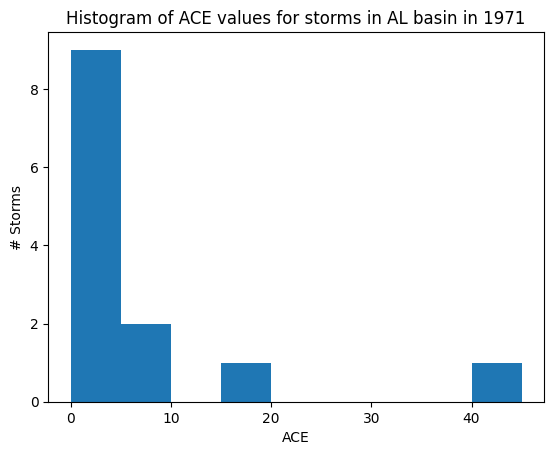

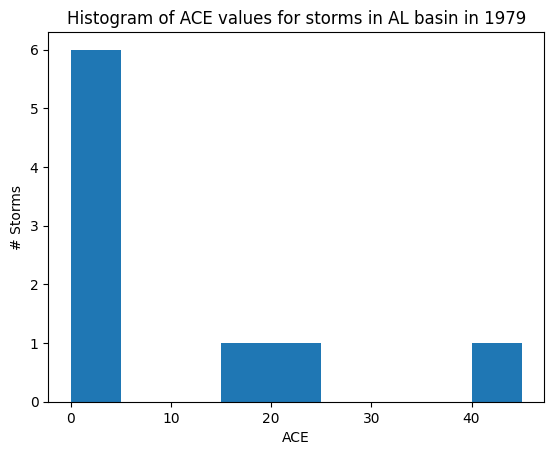

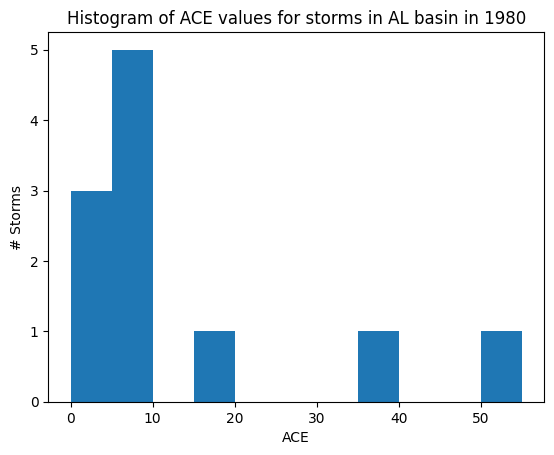

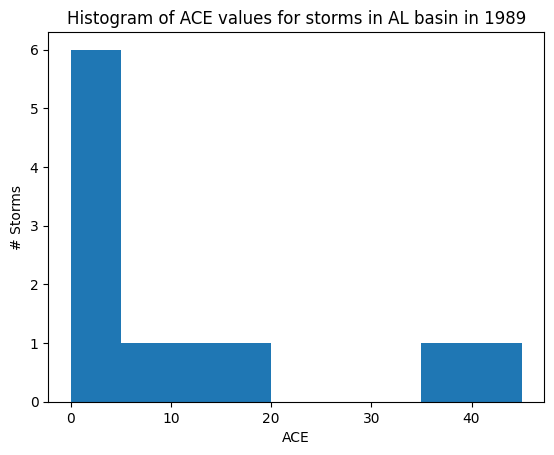

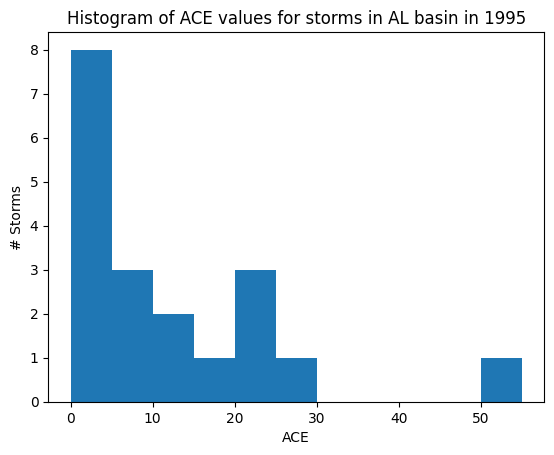

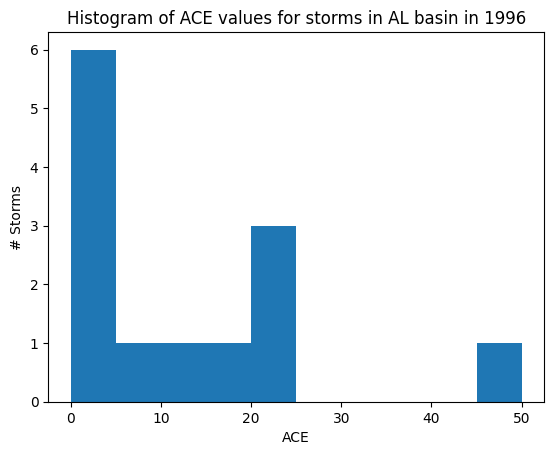

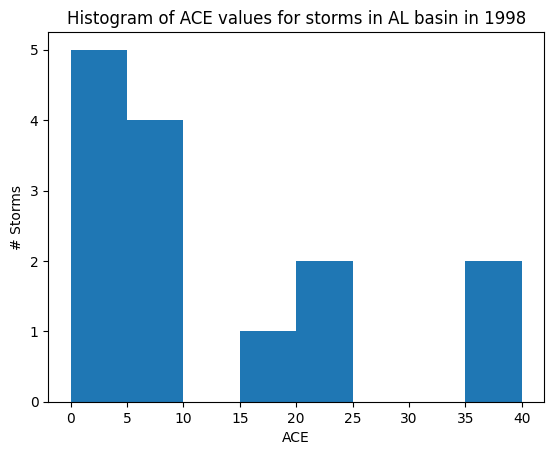

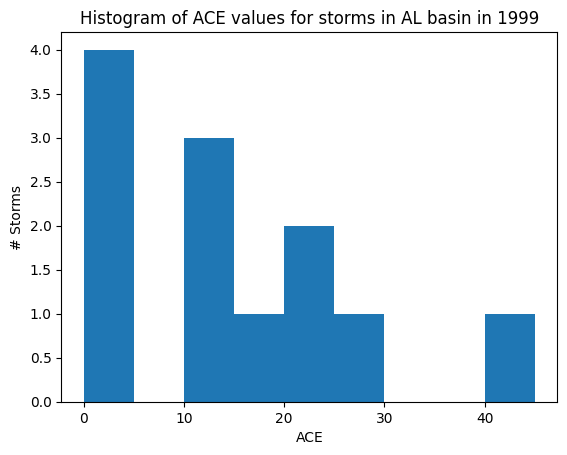

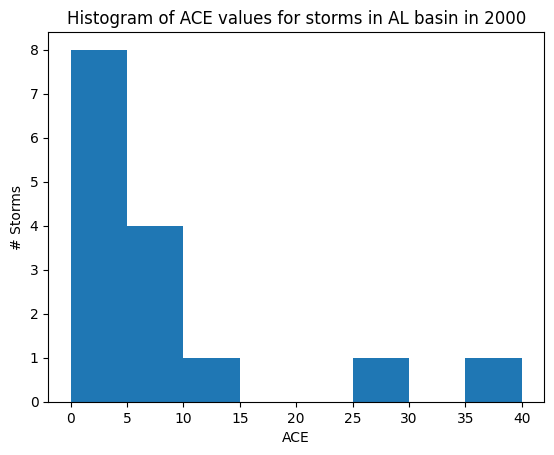

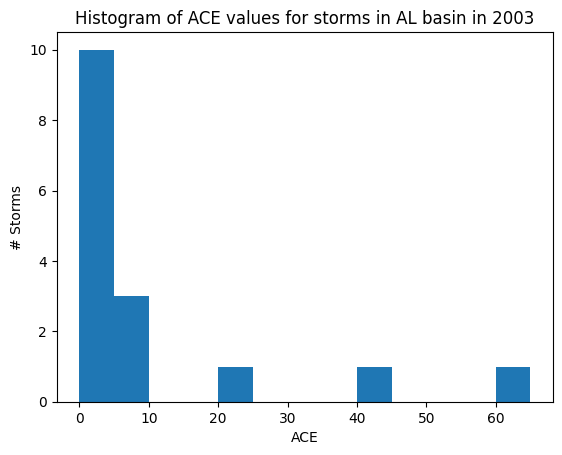

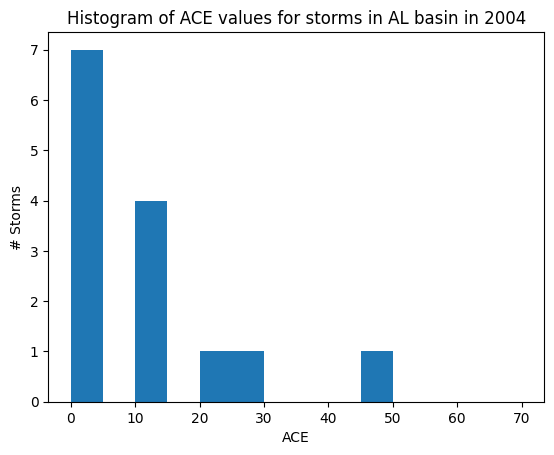

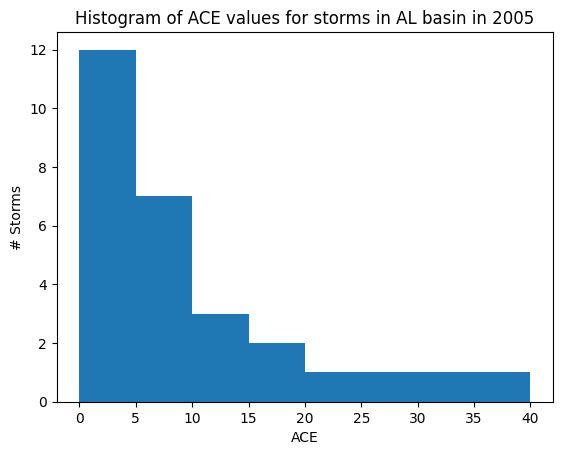

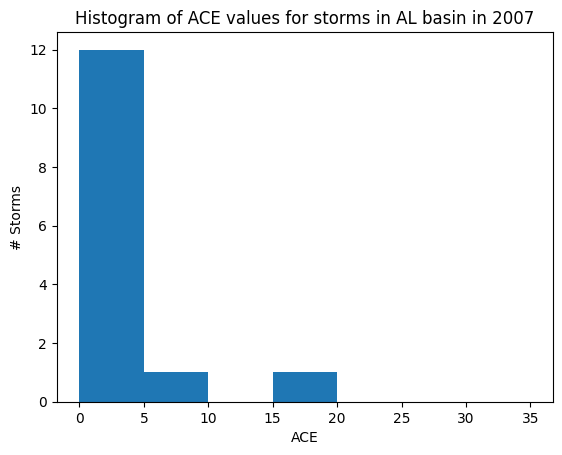

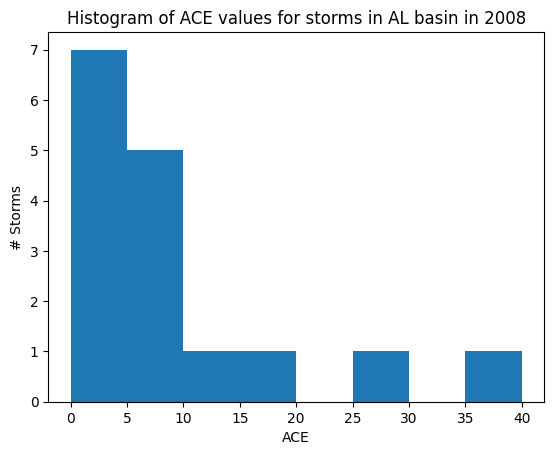

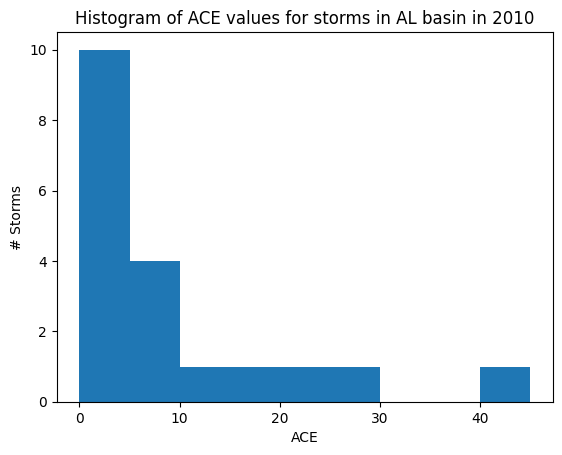

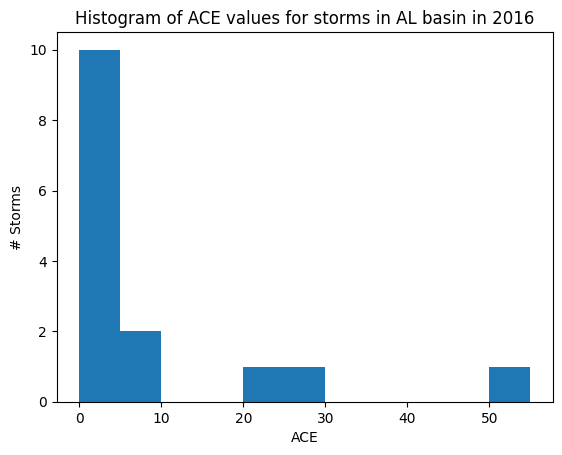

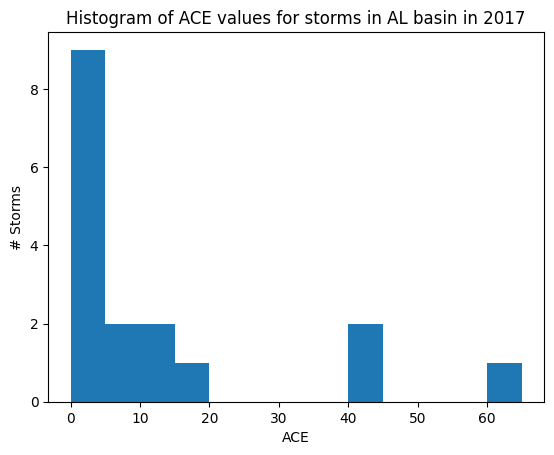

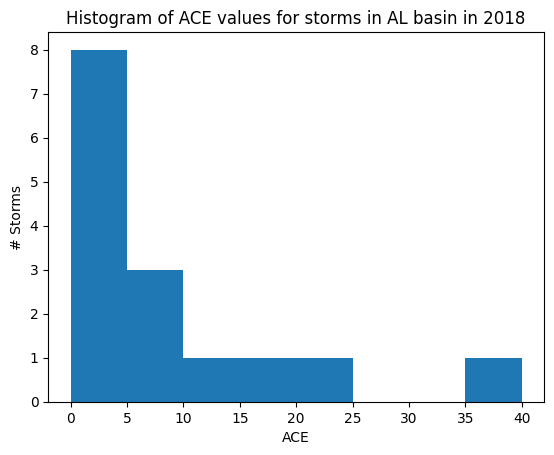

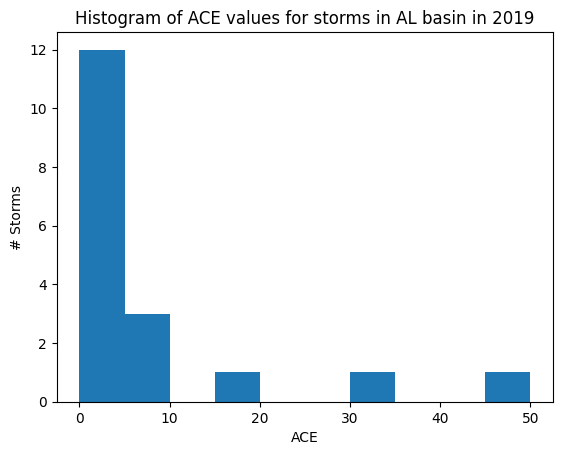

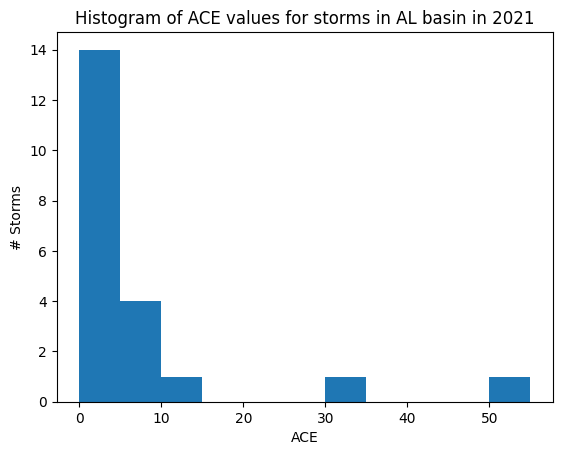

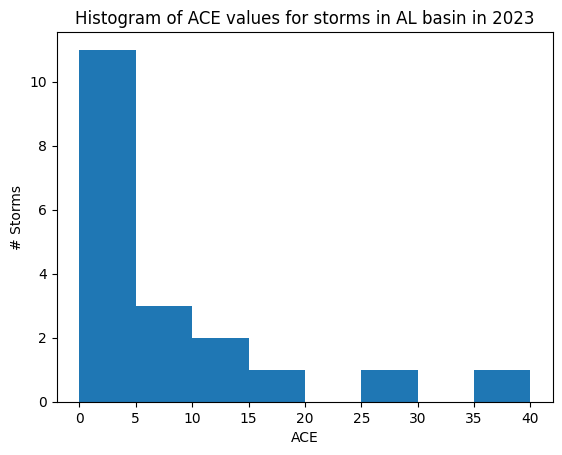

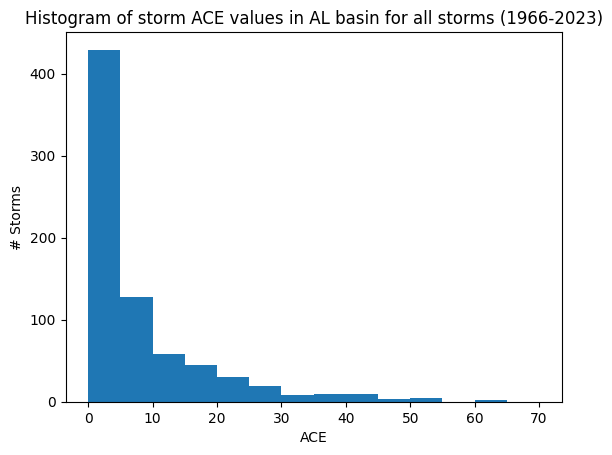

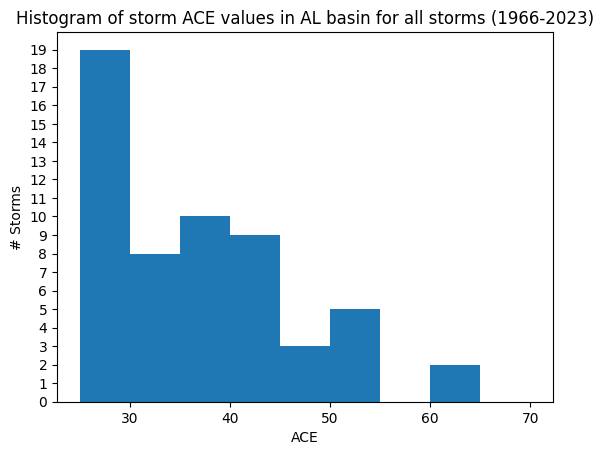

In [185]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
forecast_selected_storm_ace = 35.1

min_year = 1966  # Set the minimum year (configurable)

# Group ACE values by year
ace_by_year = {}
for atcf_id, ace in ace_by_atcf_id.items():
    year = int(atcf_id[-4:])  # Extract the year from the ATCF ID
    if year >= min_year:  # Only consider years greater than or equal to min_year
        if year not in ace_by_year:
            ace_by_year[year] = []
        ace_by_year[year].append(ace)

# Calculate the number of storms with higher ACE than forecast_selected_storm_ace
num_storms_higher_ace = 0
years_with_higher_ace = []
for year, ace_values in ace_by_year.items():
    if year >= min_year:  # Only consider years greater than or equal to min_year
        if any(ace > forecast_selected_storm_ace for ace in ace_values):
            num_storms_higher_ace += len([ace for ace in ace_values if ace > forecast_selected_storm_ace])
            years_with_higher_ace.append(year)

# Calculate the probability
num_years = len(ace_by_year)
probability = num_storms_higher_ace / num_years

# Print the results
print(f"Number of storms in AL basin with ACE > {forecast_selected_storm_ace} (since {min_year}): {num_storms_higher_ace}")
print(f"Years with storms in AL basin having ACE > {forecast_selected_storm_ace} (since {min_year}): {years_with_higher_ace}")
print(f"% of years having storms in AL basin having ACE > {forecast_selected_storm_ace} (since {min_year}): {probability*100:.1f} %")

# Plot a histogram for each year with storms having ACE >= forecast_selected_storm_ace
for year in years_with_higher_ace:
    if year >= min_year:  # Only consider years greater than or equal to min_year
        plt.hist(ace_by_year[year], bins=range(0, int(round(max(ace_by_year[year]))) + 5, 5))
        plt.title(f"Histogram of ACE values for storms in AL basin in {year}")
        plt.xlabel("ACE")
        plt.ylabel("# Storms")
        plt.show()
        
# Combine all ACE values into a single list, respecting the min_year
all_ace_values = [ace for year, ace_values in ace_by_year.items() if year >= min_year for ace in ace_values]

# Plot a histogram with all years combined, respecting the min_year
plt.hist(all_ace_values, bins=range(0, int(max(all_ace_values)) + 5, 5))
plt.title(f"Histogram of storm ACE values in AL basin for all storms ({min_year}-2023)")
plt.xlabel("ACE")
plt.ylabel("# Storms")
plt.show()

# Plot a histogram with all years combined, respecting the min_year
plt.hist(all_ace_values, bins=range(25, int(max(all_ace_values)) + 5, 5))
plt.title(f"Histogram of storm ACE values in AL basin for all storms ({min_year}-2023)")
plt.xlabel("ACE")
plt.ylabel("# Storms")

# Set the y-axis ticks to only show round numbers
yticks = ticker.MultipleLocator(1)
plt.gca().yaxis.set_major_locator(yticks)

plt.show()

Number of storms in AL basin with higher ACE than 35.1 (since 1966): 30
Years with storms in AL basin having ACE > 35.1 (since 1966): [1966, 1967, 1971, 1979, 1980, 1989, 1995, 1996, 1998, 1999, 2000, 2003, 2004, 2005, 2007, 2008, 2010, 2016, 2017, 2018, 2019, 2021, 2023]
% of years having storms in AL basin having ACE > 35.1 (since 1966): 51.7 %
Number of storms in AL basin with higher ACE than 35.1 (since 1967): 29
Years with storms in AL basin having ACE > 35.1 (since 1967): [1967, 1971, 1979, 1980, 1989, 1995, 1996, 1998, 1999, 2000, 2003, 2004, 2005, 2007, 2008, 2010, 2016, 2017, 2018, 2019, 2021, 2023]
% of years having storms in AL basin having ACE > 35.1 (since 1967): 50.9 %
Number of storms in AL basin with higher ACE than 35.1 (since 1968): 28
Years with storms in AL basin having ACE > 35.1 (since 1968): [1971, 1979, 1980, 1989, 1995, 1996, 1998, 1999, 2000, 2003, 2004, 2005, 2007, 2008, 2010, 2016, 2017, 2018, 2019, 2021, 2023]
% of years having storms in AL basin having ACE

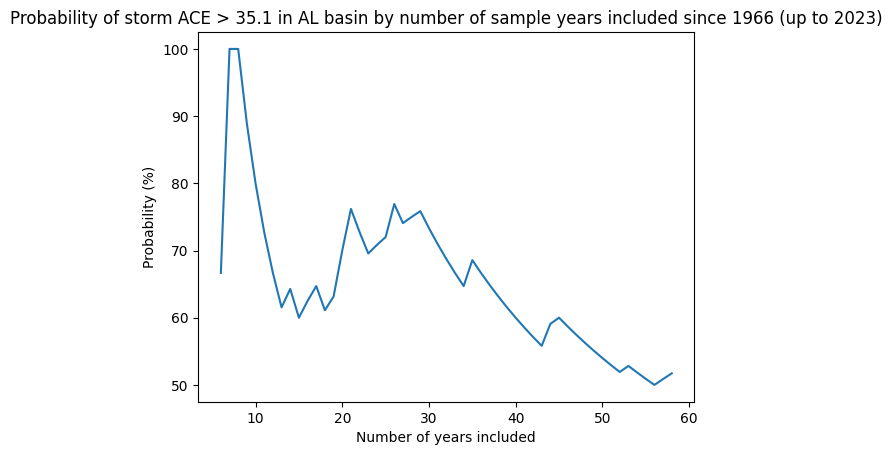

In [186]:
probabilities = {}
for min_year in range(1966, 2019):

    # Group ACE values by year
    ace_by_year = {}
    for atcf_id, ace in ace_by_atcf_id.items():
        year = int(atcf_id[-4:])  # Extract the year from the ATCF ID
        if year >= min_year:  # Only consider years greater than or equal to min_year
            if year not in ace_by_year:
                ace_by_year[year] = []
            ace_by_year[year].append(ace)

    # Calculate the number of storms with higher ACE than forecast_selected_storm_ace
    num_storms_higher_ace = 0
    years_with_higher_ace = []
    for year, ace_values in ace_by_year.items():
        if year >= min_year:  # Only consider years greater than or equal to min_year
            if any(ace > forecast_selected_storm_ace for ace in ace_values):
                num_storms_higher_ace += len([ace for ace in ace_values if ace > forecast_selected_storm_ace])
                years_with_higher_ace.append(year)

    # Calculate the probability
    num_years = len(ace_by_year)
    probability = num_storms_higher_ace / num_years
    probabilities[num_years] = probability

    # Print the results
    print(f"Number of storms in AL basin with higher ACE than {forecast_selected_storm_ace} (since {min_year}): {num_storms_higher_ace}")
    print(f"Years with storms in AL basin having ACE > {forecast_selected_storm_ace} (since {min_year}): {years_with_higher_ace}")
    print(f"% of years having storms in AL basin having ACE > {forecast_selected_storm_ace} (since {min_year}): {probability*100:.1f} %")


# Sort the probabilities by number of years in descending order
sorted_probabilities = sorted(probabilities.items(), key=lambda x: x[0], reverse=True)

# Separate the number of years and probabilities into different lists
num_years = [item[0] for item in sorted_probabilities]
probabilities_percent = [item[1] * 100 for item in sorted_probabilities]

# Plot the line chart
plt.plot(num_years, probabilities_percent)
plt.xlabel('Number of years included')
plt.ylabel('Probability (%)')
plt.title(f'Probability of storm ACE > {forecast_selected_storm_ace} in AL basin by number of sample years included since 1966 (up to 2023)')
plt.show()

In [187]:
# use this to normalize a 1-d array
def normalize(matrix):
    norm = np.linalg.norm(matrix, 1)
    matrix = matrix/norm 
    return matrix

# use exponential decay (the difference passed should always be positive)
def custom_kernel(difference, rate):
    #return (1.0 / difference)
    return np.exp(-rate * difference)

def get_min_pair_by_value(d):
    # Find the key/value pair with the minimum value from a dict
    return min(d.items(), key=lambda x: x[1])

def mean_squared_error(predictions, actual_values):
    # Ensure both dictionaries have the same keys
    common_keys = set(predictions.keys()) & set(actual_values.keys())
    
    # Calculate the squared differences and sum them
    squared_diff_sum = sum((predictions[key] - actual_values[key])**2 for key in common_keys)
    
    # Calculate the mean squared error
    mse = squared_diff_sum / len(common_keys)
    
    return mse

In [188]:
### This should be done regularly (after every day?) to get lower variance and proper decay values considering the time until to the end of the season

### TUNING & VALIDATION for decay rates and expected ACE (for this far out in year) ###

### do tuning on a partial dataset to calculate MSE and then do validation on the remaining dataset
### to make sure MSE is not too far off (this will be an estimate of the additional error/uncertainty in the tuning)

years = list(season_ace_to_time_end.keys())
years_above_real_time_ace = sorted(list(season_ace_above_real_time.keys()))

# Calculate the size of the first list (80%)
tuning_list_size = int(len(years) * 0.8)

# Randomly shuffle the original list
random.shuffle(years)

# Split the list into two new lists
years_tuning = years[:tuning_list_size]
years_validation = years[tuning_list_size:]
print(f"Tuning years: ", years_tuning)
print(f"Validation years: ", years_validation)

Tuning years:  [1983, 1987, 1998, 2010, 1985, 1976, 1989, 2000, 2002, 1974, 2023, 2004, 1994, 1980, 1988, 1966, 2017, 2013, 2019, 2001, 1999, 1981, 1970, 2005, 2012, 1975, 1986, 1978, 1977, 1967, 2022, 2009, 1997, 1972, 1979, 1973, 2006, 2003, 2015, 1968, 1990, 1969, 1991, 1993, 2021, 2011]
Validation years:  [2007, 1995, 2018, 1982, 1971, 1984, 1992, 2008, 2016, 1996, 2014, 2020]


In [189]:
# exponential decay weights
rates_to_try = list(np.round(np.arange(0.1, 0.5, 0.001),3))
#rates_to_try = [0.0001, 0.001, 0.01, 0.1, 1]
mse_by_rate = {}

# Calculate weights for each decay rate
for rate in rates_to_try:
    expected_ACE_by_tuning_year = {}
    # tune over only years for validation set
    for tuning_year in years_tuning:
        # for tuning this is the season_ace_to_time_end[tuning_year]
        tuning_ACE = season_ace_to_time_end[tuning_year]

        tuning_diff_season_ace_to_time_end = {}

        for [year, ace] in season_ace_to_time_end.items():
            if year in years_tuning and year != tuning_year:
                tuning_diff_season_ace_to_time_end[year] = tuning_ACE - ace

        # Calculate weights for each year
        weights_normalized = []
        weights = []
        for [year, diff] in tuning_diff_season_ace_to_time_end.items():        
            # Calculate weights using the custom kernel function
            weight = custom_kernel(np.abs(diff), rate)
            weights.append(weight)

        # Calculate the normalized weights
        weights_normalized = normalize(weights)

        # Calculate expected ACE using normalized weights
        expected_ACE = 0.0
        for [x, year] in list(enumerate(tuning_diff_season_ace_to_time_end)):
            expected_ACE += (weights_normalized[x] * season_ace[year])
        #print(tuning_diff_season_ace_to_time_end)

        expected_ACE_by_tuning_year[tuning_year] = expected_ACE
    
    # calculate the MSE for this rate
    #print(expected_ACE_by_tuning_year)
    mse = mean_squared_error(expected_ACE_by_tuning_year, season_ace)
    mse_by_rate[rate] = mse

In [190]:
tuning_min_pair = get_min_pair_by_value(mse_by_rate)
print(f"(Validation) Rate , MSE (minimum) for tuning dataset: {tuning_min_pair}")

(Validation) Rate , MSE (minimum) for tuning dataset: (0.161, 1102.5809120389374)


In [191]:
# TUNING above has minimum MSE for:
# Rate: 0.14, MSE: 578.8630529802942

In [192]:
## VALIDATION
# exponential decay weights
rates_to_try = list(np.round(np.arange(0.05, 0.5, 0.001),3))
#rates_to_try = [0.0001, 0.001, 0.01, 0.1, 1]
mse_by_rate = {}

# Calculate weights for each decay rate
for rate in rates_to_try:
    expected_ACE_by_validation_year = {}
    for validation_year in years_validation:
        # for validation this is the season_ace_to_time_end[validation_year]
        validation_ACE = season_ace_to_time_end[validation_year]

        validation_diff_season_ace_to_time_end = {}

        for [year, ace] in season_ace_to_time_end.items():
            if year in years_validation and year != validation_year:
                validation_diff_season_ace_to_time_end[year] = validation_ACE - ace

        # Calculate weights for each year
        weights_normalized = []
        weights = []
        for [year, diff] in validation_diff_season_ace_to_time_end.items():        
            # Calculate weights using the custom kernel function
            weight = custom_kernel(np.abs(diff), rate)
            weights.append(weight)

        # Calculate the normalized weights
        weights_normalized = normalize(weights)
        if rate == 1.184:
            print(weights_normalized)
        # Calculate expected ACE using normalized weights
        expected_ACE = 0.0
        for [x, year] in list(enumerate(validation_diff_season_ace_to_time_end)):
            expected_ACE += (weights_normalized[x] * season_ace[year])

        expected_ACE_by_validation_year[validation_year] = expected_ACE
    
    # calculate the MSE for this rate
    #print(expected_ACE_by_validation_year)
    mse = mean_squared_error(expected_ACE_by_validation_year, season_ace)
    mse_by_rate[rate] = mse
    

In [193]:
validation_min_pair = get_min_pair_by_value(mse_by_rate)
print(f"(Validation) Rate : MSE (minimum) for validation dataset: {validation_min_pair}")

(Validation) Rate : MSE (minimum) for validation dataset: (0.073, 1976.6702065744812)


In [194]:
# for validation, the minimum MSE:
# Rate: 0.102, MSE: 439.9012525009955
# from the validation-tuning set above, the tuning Rate: 0.14, MSE: 450.0207460685012

rmse_tuning = pow(tuning_min_pair[1], 0.5)
rmse_validation = pow(validation_min_pair[1], 0.5)
diff_rmse = abs(rmse_tuning - rmse_validation)
print(f"RMSE tuning: {rmse_tuning:.2f}")
print(f"RMSE validation: {rmse_validation:.2f}")
print(f"Difference of RMSE(tuning) - RMSE(validation): {diff_rmse:.2f}")

RMSE tuning: 33.21
RMSE validation: 44.46
Difference of RMSE(tuning) - RMSE(validation): 11.25


In [195]:
# FINAL TUNING

# exponential decay weights
rates_to_try = list(np.round(np.arange(0.05, 0.5, 0.001),3))
#rates_to_try = [0.0001, 0.001, 0.01, 0.1, 1]
mse_by_rate = {}

# Calculate weights for each decay rate
for rate in rates_to_try:
    expected_ACE_by_tuning_year = {}
    # tune over all years
    for tuning_year in years:
        # for tuning this is the season_ace_to_time_end[tuning_year]
        tuning_ACE = season_ace_to_time_end[tuning_year]

        tuning_diff_season_ace_to_time_end = {}

        for [year, ace] in season_ace_to_time_end.items():
            if year in years and year != tuning_year:
                tuning_diff_season_ace_to_time_end[year] = tuning_ACE - ace

        # Calculate weights for each year
        weights_normalized = []
        weights = []
        for [year, diff] in tuning_diff_season_ace_to_time_end.items():        
            # Calculate weights using the custom kernel function
            weight = custom_kernel(np.abs(diff), rate)
            weights.append(weight)

        # Calculate the normalized weights
        weights_normalized = normalize(weights)

        # Calculate expected ACE using normalized weights
        expected_ACE = 0.0
        for [x, year] in list(enumerate(tuning_diff_season_ace_to_time_end)):
            expected_ACE += (weights_normalized[x] * season_ace[year])
        #print(tuning_diff_season_ace_to_time_end)

        expected_ACE_by_tuning_year[tuning_year] = expected_ACE
    
    # calculate the MSE for this rate
    #print(expected_ACE_by_tuning_year)
    mse = mean_squared_error(expected_ACE_by_tuning_year, season_ace)
    mse_by_rate[rate] = mse
    #print(f"Rate: {rate}, MSE: {mse}")

final_tuning_min_pair = get_min_pair_by_value(mse_by_rate)
print(f"(Tuning Final) Rate : MSE (minimum) for all past years: {final_tuning_min_pair}")

(Tuning Final) Rate : MSE (minimum) for all past years: (0.098, 1302.8451119186511)


In [196]:
# minimum is Rate: 0.147, MSE: 518.519969751831
mse_final_tuning = final_tuning_min_pair[1]
rate_final_tuning = final_tuning_min_pair[0]
print(f"Rate final tuning: {rate_final_tuning:0.4f}")
print(f"MSE final tuning: {mse_final_tuning:.2f}")
rmse_final_tuning = pow(mse_final_tuning,0.5)
print("")
print(f"RMSE final tuning: {rmse_final_tuning:.2f}")

Rate final tuning: 0.0980
MSE final tuning: 1302.85

RMSE final tuning: 36.09


In [197]:
def calculate_expected_ACE(this_season_end = season_ace_to_time_end, repeat_counts = None):
    diff_season_ace_to_time_end = {}

    for [year, ace] in this_season_end.items():
        diff_season_ace_to_time_end[year] = present_ACE - ace

    # exponential decay weights
    #rates_to_try = list(np.round(np.arange(0.080, 0.205, 0.005),3))
    rates_to_try = [rate_final_tuning]

    expected_ACE_by_rate = {}
    weights_normalized_by_year = {}
    # Calculate weights for each decay rate
    for rate in rates_to_try:
        # Calculate weights for each year
        weights_normalized = []
        weights = []
        for [year, diff] in diff_season_ace_to_time_end.items():        
            # Calculate weights using the custom kernel function
            weight = custom_kernel(np.abs(diff), rate)
            weights.append(weight)

        # Calculate the normalized weights
        weights_normalized = normalize(weights)

        # store weights by year for useful statistics
        weights_normalized_by_year = {}

        weights_total = 0.0
        # Calculate expected ACE using normalized weights
        expected_ACE = 0.0
        for [x, year] in list(enumerate(diff_season_ace_to_time_end)):
            weights_normalized_by_year[year] = weights_normalized[x]
            if repeat_counts:
                repeat_count = repeat_counts[year]
                # can't just multiply by repeat_count without renormalizing
                expected_ACE += (repeat_count * (weights_normalized[x] * season_ace[year]))
                weights_total += repeat_count * weights_normalized[x]
            else:
                expected_ACE += (weights_normalized[x] * season_ace[year])
                weights_total += weights_normalized[x]

        # renormalize (only affected if repeat_counts is set)
        if weights_total == 0:
            expected_ACE_by_rate[rate] = 0
        else:
            expected_ACE_by_rate[rate] = expected_ACE / weights_total

    expected_ACE = expected_ACE_by_rate[rate_final_tuning]

    return [expected_ACE, weights_normalized_by_year]


Valid until: 2024-09-07 12:00:00
ACE, Real-time + storm model forecast: 55.1
Tuned decay rate: 0.098

Expected ACE (weight historical ACE using exponential decay): 125.96


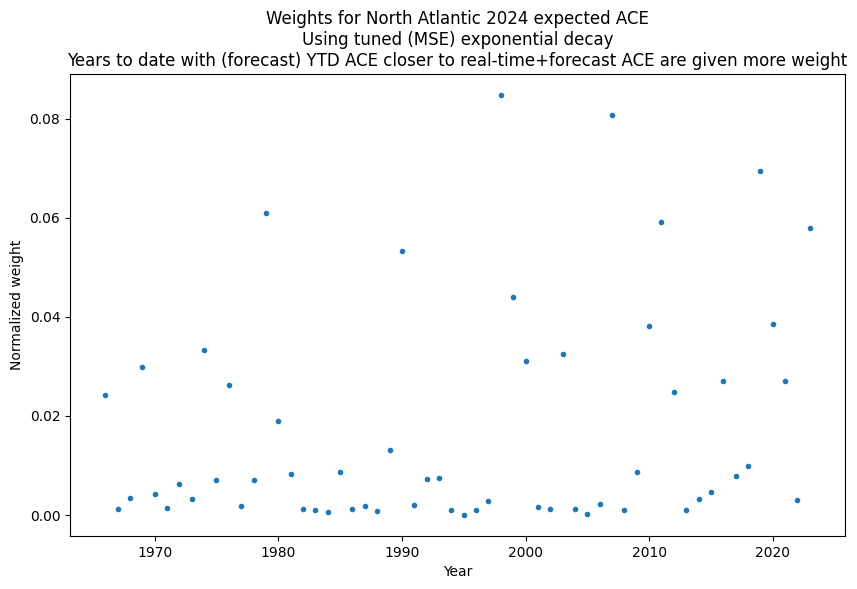

Top 10 weights (sorted by weight)
----------------------------------------
Rank  |  Year  |  Weight  |  Season ACE
----------------------------------------
   1  |  1998  |  0.085   |  181.16
   2  |  2007  |  0.081   |  73.89
   3  |  2019  |  0.069   |  132.20
   4  |  1979  |  0.061   |  92.92
   5  |  2011  |  0.059   |  126.30
   6  |  2023  |  0.058   |  146.79
   7  |  1990  |  0.053   |  96.80
   8  |  1999  |  0.044   |  176.53
   9  |  2020  |  0.038   |  180.37
  10  |  2010  |  0.038   |  165.48


In [198]:
# real-time ACE plus forecast ace (until ace_time_end_str)
# use a manually entered value
present_ACE = 122.65
# or the value from the forecast
present_ACE = total_ace_until_forecast
####################################

[expected_ACE, weights_normalized_by_year] = calculate_expected_ACE()
    
pop_ace_values = list(season_ace_above_real_time.values())
n_pop_ace_values = len(pop_ace_values)
ace_stddev = np.std(pop_ace_values)
ace_mean = np.mean(pop_ace_values)
ace_median = np.median(pop_ace_values)
z_score = (expected_ACE - ace_mean) / ace_stddev

sorted_years = sorted(years)

print(f"Valid until:", ace_time)
print(f"ACE, Real-time + storm model forecast: {total_ace_until_forecast:3.1f}")
print("Tuned decay rate:", rate_final_tuning)
print("")
print(f"Expected ACE (weight historical ACE using exponential decay): {expected_ACE:3.2f}")

expected_ACE_years = list(weights_normalized_by_year.keys())
expected_ACE_weights = list(weights_normalized_by_year.values())

# Plot the values of the weights
plt.figure(figsize=(10, 6))
plt.plot(expected_ACE_years, expected_ACE_weights, marker='.', linestyle='')
plt.xlabel('Year')
plt.ylabel('Normalized weight')
plt.title('Weights for North Atlantic 2024 expected ACE\nUsing tuned (MSE) exponential decay\nYears to date with (forecast) YTD ACE closer to real-time+forecast ACE are given more weight')
plt.show()

# Print out the ranking of weights
num_weights_in_table = 10

# Sort the dictionary items by values in descending order
sorted_weights_by_year = dict(
    sorted(weights_normalized_by_year.items(), key=lambda x: float(x[1]), reverse=True)[:num_weights_in_table]
)

# Convert NumPy values to regular Python types
sorted_weights_by_year = {int(year): float(weight) for year, weight in sorted_weights_by_year.items()}

# Print the table header
print(f"Top {num_weights_in_table} weights (sorted by weight)")
print("-" * 40)
print("Rank  |  Year  |  Weight  |  Season ACE")
print("-" * 40)

# Iterate through the first X items and print the rank, year, and weight
for rank, (year, weight) in enumerate(sorted_weights_by_year.items(), start=1):
    print(f"{rank:4}  |  {year:4}  |  {weight:.3f}   |  {season_ace[year]:3.2f}")


ACE=73 (exp. decay) %: 100.00 %
ACE=126 (exp. decay) %: 49.10 %
ACE=160 (exp. decay) %: 0.00 %
ACE=258 (exp. decay) %: 0.00 %
ACE=160 (exp. decay) %: 0.00 %
ACE=161 (exp. decay) %: 0.00 %


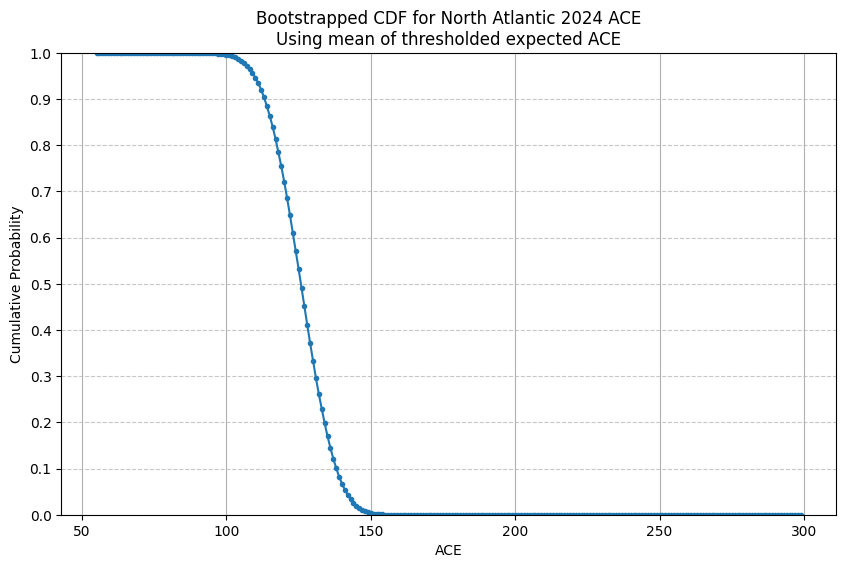


ACE=160 (excluding years below real time ACE) %: 0.00 %
ACE=161 (excluding years below real time ACE) %: 0.00 %


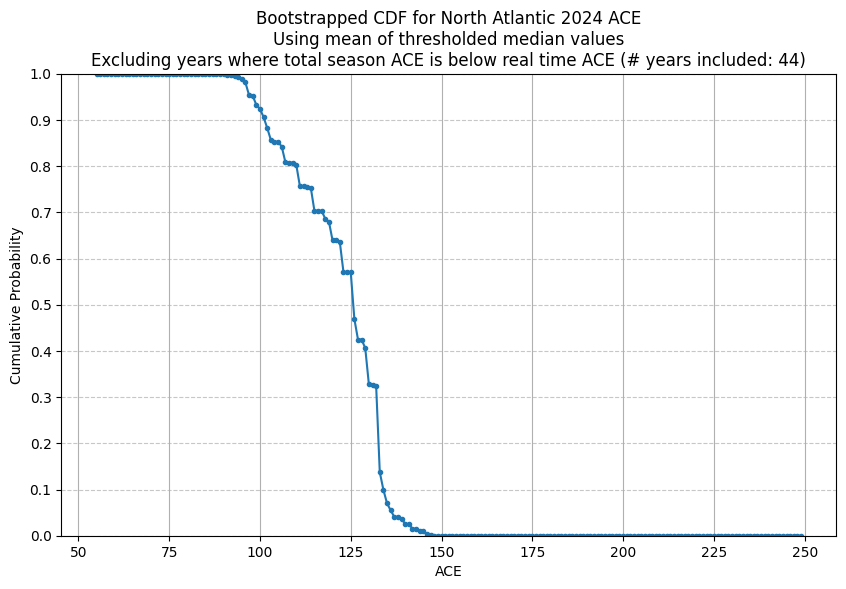


% chance of ACE=160 using average of two probabilities: 0.00%

Statistics for 1966 - 2023 excluding years with season ACE < real time ACE:
μ: 125.95
median: 125.87



In [263]:
# Specify the confidence level (e.g., 90% CI)
confidence_level = 0.7

# use bootstrapping instead for CI

# Number of bootstrap samples to generate
num_samples = 100000

# Calculate the statistic of interest (e.g., mean) for the original data
original_statistic = expected_ACE

# Initialize an array to store resampled statistics
resampled_statistics = np.empty(num_samples)

# Range of values for CDF estimation
#values_of_interest = list(range(round(real_time_ACE), round(max(pop_ace_values)), 1))
values_of_interest = list(range(round(real_time_ACE), round(300), 1))

# store when the median is greater than each value of interest
binary_outcomes = np.empty((num_samples, len(values_of_interest)))

# Perform bootstrapping
for i in range(num_samples):
    # Generate a resampled dataset by sampling with replacement
    
    # cannot do random choice on a dict...
    #resampled_data = np.random.choice(season_ace_above_real_time, size=len(season_ace_above_real_time), replace=True)
    
    num_sample_years = len(season_ace_above_real_time)  # Number of samples you want to draw
    # Randomly select keys from the dictionary with replacement
    random_keys = random.choices(list(season_ace_to_time_end.keys()), k=num_sample_years)
    # Use the selected keys to access corresponding values
    random_values = [season_ace_to_time_end[key] for key in random_keys]
    
    # since I need to pass a dict that should have multiple keys repeated, do something extra to keep track of the 'repeats'
    repeat_counts = dict(Counter(random_keys))
    
    resampled_data = {key: value for key, value in zip(random_keys, random_values)}
    
    # Calculate the statistic of interest for the resampled dataset
    [resampled_statistic, weights_normalized_by_year] = calculate_expected_ACE(resampled_data, repeat_counts)
    
    # Store the resampled statistic
    resampled_statistics[i] = resampled_statistic
    
    # Threshold on the values of interest using the expected ACE
    binary_outcome = []
    for value in values_of_interest:
        if resampled_statistic < value:
            binary_outcome.append(0)
        else:
            binary_outcome.append(1)
    binary_outcomes[i] = binary_outcome
    
# Calculate the CDF for each value of interest (using the average of the thresholded binary outcomes)
cdf = np.mean(binary_outcomes, axis=0)

print("")

selected_ace_values = [73, 126.1, 159.6, 258.47]
for selected_ace in selected_ace_values:
    rounded_ace = int(round(selected_ace))
    print(f"ACE={rounded_ace} (exp. decay) %: {cdf[values_of_interest.index(rounded_ace)]*100:2.2f} %")
    

print(f"ACE=160 (exp. decay) %: {cdf[values_of_interest.index(160)]*100:2.2f} %")
print(f"ACE=161 (exp. decay) %: {cdf[values_of_interest.index(161)]*100:2.2f} %")
prob_exp = cdf[values_of_interest.index(160)]


# Plot the CDF
plt.figure(figsize=(10, 6))
plt.plot(values_of_interest, cdf, marker='.', linestyle='-')
plt.xlabel('ACE')
plt.ylabel('Cumulative Probability')
plt.title('Bootstrapped CDF for North Atlantic 2024 ACE\nUsing mean of thresholded expected ACE')

# Set y-axis limits to 0.0 and 1.0
plt.ylim(0.0, 1.0)

# Customize y-axis ticks and grid lines at intervals of 0.1
plt.yticks(np.arange(0, 1.1, 0.1))
plt.gca().yaxis.grid(True, linestyle='--', alpha=0.7)
plt.grid(True)
plt.show()

# Calculate the lower and upper bounds of the confidence interval
alpha = 1 - confidence_level
lower_bound = np.percentile(resampled_statistics, 100 * alpha / 2)
upper_bound = np.percentile(resampled_statistics, 100 * (1 - alpha / 2))

# Print the results
#print(f"(bootstrapped) CI using expected value ({confidence_level*100:2.1f}%): [{lower_bound:3.2f}, {upper_bound:3.2f}]")

# use bootstrapping instead for CI

# Number of bootstrap samples to generate
num_samples = 100000

# Calculate the statistic of interest (e.g., mean) for the original data
original_statistic = ace_median

# Initialize an array to store resampled statistics
resampled_statistics = np.empty(num_samples)

# Range of values for CDF estimation
values_of_interest = list(range(round(real_time_ACE), round(max(pop_ace_values)), 1))

# Initialize an array to store CDF from bootstraps
binary_outcomes = np.empty((num_samples, len(values_of_interest)))

# Perform bootstrapping
for i in range(num_samples):
    # Generate a resampled dataset by sampling with replacement
    resampled_data = np.random.choice(pop_ace_values, size=len(pop_ace_values), replace=True)
    
    # Calculate the statistic of interest for the resampled dataset
    resampled_statistic = np.median(resampled_data)
    
    # Store the resampled statistic
    resampled_statistics[i] = resampled_statistic

    # Threshold on the values of interest using the expected ACE
    binary_outcome = []
    for value in values_of_interest:
        if resampled_statistic < value:
            binary_outcome.append(0)
        else:
            binary_outcome.append(1)
    binary_outcomes[i] = binary_outcome
    
# Calculate the CDF for each value of interest (using the average of the thresholded binary outcomes)
cdf = np.mean(binary_outcomes, axis=0)
print("")

print(f"ACE=160 (excluding years below real time ACE) %: {cdf[values_of_interest.index(160)]*100:2.2f} %")
print(f"ACE=161 (excluding years below real time ACE) %: {cdf[values_of_interest.index(161)]*100:2.2f} %")
prob_realtime = cdf[values_of_interest.index(160)]

# Plot the CDF
plt.figure(figsize=(10, 6))
plt.plot(values_of_interest, cdf, marker='.', linestyle='-')

plt.xlabel('ACE')
plt.ylabel('Cumulative Probability')
plt.title(f'Bootstrapped CDF for North Atlantic 2024 ACE\nUsing mean of thresholded median values\nExcluding years where total season ACE is below real time ACE (# years included: {n_pop_ace_values})')

# Set y-axis limits to 0.0 and 1.0
plt.ylim(0.0, 1.0)

# Customize y-axis ticks and grid lines at intervals of 0.1
plt.yticks(np.arange(0, 1.1, 0.1))
plt.gca().yaxis.grid(True, linestyle='--', alpha=0.7)

plt.grid(True)
plt.show()
    
# not useful with long tail
# Specify the confidence level (e.g., 90% CI)
confidence_level = 0.54

# Calculate the lower and upper bounds of the confidence interval
alpha = 1 - confidence_level
lower_bound = np.percentile(resampled_statistics, 100 * alpha / 2)
upper_bound = np.percentile(resampled_statistics, 100 * (1 - alpha / 2))


# Print the results
#print(f"(bootstrapped) CI using median ({confidence_level*100:2.1f}%): [{lower_bound:3.2f}, {upper_bound:3.2f}]")
print("")
avg_of_two_at_160 = (prob_realtime + prob_exp) / 2
print(f"% chance of ACE=160 using average of two probabilities: {avg_of_two_at_160*100:2.2f}%")

print("")
print(f"Statistics for {sorted_years[0]} - {sorted_years[-1]} excluding years with season ACE < real time ACE:")
print(f"μ: {ace_mean:3.2f}")
print(f"median: {ace_median:3.2f}")

# not as useful since it doesn't handle constraints well so don't use general statistics below for CI:
#print("σ:", ace_stddev)
#print("Z score for expected ACE:", z_score)
#ci_lower = expected_ACE - (critical_value * ace_stddev)
#ci_upper = expected_ACE + (critical_value * ace_stddev)
#print(f"CI({confidence_level}) = [ {ci_lower} , {ci_upper} ]")


# expect the tuned decay rate should automatically increase as the season passes
#   this means, later in the season it will be more selective in using years that have ACE that are very close to the present
#   as opposed to early in the season when the years will be more of an average
# for instance on Sept 24 06Z it was 0.147, and on Sept 25 00Z it was 0.171
print("")

In [266]:
# diagnostics for model predictiveness as the season progresses
expected_ACE_upper = expected_ACE + rmse_final_tuning
expected_ACE_lower = expected_ACE - rmse_final_tuning
#print(f"Range using RMSE (without validation RMSE): {expected_ACE_lower} : {expected_ACE_upper}")
expected_ACE_upper_with_validation_z1 = expected_ACE + (rmse_final_tuning + diff_rmse)
expected_ACE_lower_with_validation_z1 = expected_ACE - (rmse_final_tuning + diff_rmse)
expected_ACE_upper_with_validation_z2 = expected_ACE + 2 * (rmse_final_tuning + diff_rmse)
expected_ACE_lower_with_validation_z2 = expected_ACE - 2 * (rmse_final_tuning + diff_rmse)
#print(f"Range using RMSE (with validation RMSE):    {expected_ACE_lower_with_validation} : {expected_ACE_upper_with_validation}")

In [200]:
# weight two predictors by sample size
# first predictor must account for unequal weights (inflating the sample size)
# consider for reference where all weights are given equal value (1/n)
#    then, for a weight that is less than or equal to 1/10 of (1/n),
#    let us consider such a weight as not contributing enough and is inflating the sample size
num_total_weights = len(sorted_weights_by_year)
contributing_threshold = (1/10) * (1/num_total_weights)
num_contributing_weights = 0
for rank, (year, weight) in enumerate(sorted_weights_by_year.items(), start=1):
    if weight > contributing_threshold:
        num_contributing_weights += 1
n1 = num_contributing_weights
n2 = n_pop_ace_values
w1 = n1 / (n1 + n2)
w2 = n2 / (n1 + n2)
# normalize weights
w1 = w1 / (w1 + w2)
w2 = w2 / (w1 + w2)
p_weighted = prob_exp*w1 + prob_realtime*w2
print(f"(ACE=160) Weighting the two predictors: (weighting Exp: {w1:.1f}, Realtime: {w2:.1f}): {p_weighted*100:.2f}%")

(ACE=160) Weighting the two predictors: (weighting Exp: 0.2, Realtime: 0.8): 0.00%


In [201]:
with open('season_ace.csv', 'w') as file:
    for [year,ace] in season_ace.items():
        file.write(f"{year}, {ace}\n")

In [ ]:
raise Exception('STOP HERE')

0.005424

In [ ]:
raise Exception('STOP HERE')

In [210]:
def load_data_from_json(filename):
    with open(filename, 'r') as f:
        data = json.load(f)
    return data


fatalities = load_data_from_json('fatalities_min.json')
economic_damages_in_2024_usd = load_data_from_json('cleaned_economic_damages_min_in_2024usd.json')

expected_fatalities = 0
expected_damages = 0
total_weights = 0
for year, weight in weights_normalized_by_year.items():
    year_str = str(year)
    expected_fatalities += weight * fatalities[year_str]
    expected_damages += weight * economic_damages_in_2024_usd[year_str]
    total_weights += weight
    
print(f"Expected fatalaties in 2024 by ACE model: {expected_fatalities} deaths")
print(f"Expected economic damages in 2024 by ACE model: ${expected_damages} (2024 USD)")


Expected fatalaties in 2024 by ACE model: 2026.4452783522786 deaths
Expected economic damages in 2024 by ACE model: $24160270369.14096 (2024 USD)


In [299]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr, norm
import scipy.stats as stats

import matplotlib.pyplot as plt
import math

baseline_years = 60
season_ace_above_real_time_recent = {year: value for year, value in season_ace_above_real_time.items() if year >= max(season_ace_above_real_time.keys()) - baseline_years}

# Convert string years to integer years in fatalities and economic_damages_in_2024_usd
fatalities = {int(k): v for k, v in fatalities.items()}
economic_damages_in_2024_usd = {int(k): v for k, v in economic_damages_in_2024_usd.items()}

# Filter data to include only years present in all three dictionaries
years = set(season_ace_above_real_time_recent.keys()) & set(fatalities.keys()) & set(economic_damages_in_2024_usd.keys())

# Create DataFrames
df_fatalities = pd.DataFrame({'Year': list(years), 
                             'ACE': [season_ace_above_real_time_recent[y] for y in years], 
                             'Fatalities': [fatalities[y] for y in years]})

df_economic = pd.DataFrame({'Year': list(years), 
                           'ACE': [season_ace_above_real_time_recent[y] for y in years], 
                           'Economic_Damages': [economic_damages_in_2024_usd[y] for y in years]})

# Parametric Model (e.g., linear regression)
def exceedance_probability(model, x):
    mean, std = model.predict(), model.std()
    return 1 - norm.cdf(x, loc=mean, scale=std)

# Function to perform statistical tests and model fitting
def analyze_data(df, target):
    # Split data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(df[['ACE']], df[target], test_size=0.2, random_state=42)

    # Models to test
    models = {
        'Linear': LinearRegression(),
        'Logarithmic': make_pipeline(PolynomialFeatures(degree=1), LinearRegression()),
        'Exponential': make_pipeline(PolynomialFeatures(degree=1), LinearRegression()),
        'Polynomial (Degree 2)': make_pipeline(PolynomialFeatures(degree=2), LinearRegression()),
        'Polynomial (Degree 3)': make_pipeline(PolynomialFeatures(degree=3), LinearRegression())
    }

    # Perform statistical tests and model fitting
    results = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        mse = mean_squared_error(y_val, y_pred)
        rmse = np.power(mse, 0.5)
        results[name] = {
            'R-Squared': r2_score(y_val, y_pred),
            'MSE': round(mean_squared_error(y_val, y_pred)),
            'RMSE': round(rmse),
            'p-value': pearsonr(df['ACE'], df[target])[1],
            'model': model
        }

    # Determine best model
    best_model = max(results, key=lambda x: results[x]['R-Squared'])

    return results, best_model

# Analyze fatalities data
fatalities_results, best_fatalities_model = analyze_data(df_fatalities, 'Fatalities')

# Analyze economic damages data
economic_results, best_economic_model = analyze_data(df_economic, 'Economic_Damages')

# Print results
print('Fatalities Analysis:')
for model, metrics in fatalities_results.items():
    print(f'{model}: R-Squared = {metrics["R-Squared"]:.3f}, MSE = {metrics["MSE"]}, RMSE = {metrics["RMSE"]}, p-value = {metrics["p-value"]:.3f}')

print(f'\nBest Fatalities Model: {best_fatalities_model}')

print('\nEconomic Damages Analysis:')
for model, metrics in economic_results.items():
    print(f'{model}: R-Squared = {metrics["R-Squared"]:.3f}, MSE = {metrics["MSE"]}, RMSE = {metrics["RMSE"]}, p-value = {metrics["p-value"]:.3f}')

print(f'\nBest Economic Damages Model: {best_economic_model}')

expected_ace_values = [expected_ACE_lower_with_validation_z2, expected_ACE_lower_with_validation_z1, expected_ACE, expected_ACE_upper_with_validation_z1, expected_ACE_upper_with_validation_z2]
years = [2024] * len(expected_ace_values)
expected_ace_df = pd.DataFrame({'Year': years, 'ACE': expected_ace_values})

print("Using ACE values of (lower (Z=1), expected (exponential decay), upper):", expected_ace_df)

# Calculate expected values and CI for Fatalities
fatalities_expected = fatalities_results[best_fatalities_model]['model'].predict(expected_ace_df[['ACE']])
fatalities_rmse = fatalities_results[best_fatalities_model]['MSE'] ** 0.5
fatalities_ci = 1 * fatalities_rmse  # z-score of 1

print('Fatalities Expected Values with CI:')
for year, expected, ci in zip(years, fatalities_expected, [fatalities_ci] * len(df_fatalities)):
    print(f'Year: {year}, Expected: {expected:.2f}, CI: ({max(0,expected - ci):.2f}, {expected + ci:.2f})')

# Calculate expected values and CI for Economic Damages
economic_expected = economic_results[best_economic_model]['model'].predict(expected_ace_df[['ACE']])
economic_rmse = economic_results[best_economic_model]['MSE'] ** 0.5
economic_ci = 1 * economic_rmse  # z-score of 1

print('\nEconomic Damages Expected Values with CI:')
for year, expected, ci in zip(years, economic_expected, [economic_ci] * len(df_economic)):
    print(f'Year: {year}, Expected: {expected:.2e}, CI: ({max(0, expected - ci):.2e}, {expected + ci:.2e})')


# Calculate expected values and CI for Fatalities
fatalities_expected = fatalities_results[best_fatalities_model]['model'].predict(expected_ace_df[['ACE']])
fatalities_rmse = fatalities_results[best_fatalities_model]['MSE'] ** 0.5
fatalities_ci = 1 * fatalities_rmse  # z-score of 1
fatalities_exceedance_threshold = 3000

max_fatal_p = 0

print('Fatalities Expected Values with CI and Exceedance Probability:')
for year, expected, ci in zip(years, fatalities_expected, [fatalities_ci] * len(df_fatalities)):
    exceedance_prob = 1 - stats.norm.cdf(fatalities_exceedance_threshold, loc=expected, scale=fatalities_rmse)
    max_fatal_p = max(max_fatal_p, exceedance_prob)
    print(f'Year: {year}, Expected: {max(0, expected):.2f}, CI: ({max(0,expected - ci):.2f}, {expected + ci:.2f}),'
          f' Exceedance Prob ({fatalities_exceedance_threshold} fatalities): {exceedance_prob:.4f}')

# Calculate expected values and CI for Economic Damages
economic_expected = economic_results[best_economic_model]['model'].predict(expected_ace_df[['ACE']])
economic_rmse = economic_results[best_economic_model]['MSE'] ** 0.5
economic_ci = 1 * economic_rmse  # z-score of 1
economic_exceedance_threshold = 295000000000

max_damages_p = 0
print('\nEconomic Damages Expected Values with CI and Exceedance Probability:')
for year, expected, ci in zip(years, economic_expected, [economic_ci] * len(df_economic)):
    exceedance_prob = 1 - stats.norm.cdf(economic_exceedance_threshold, loc=expected, scale=economic_rmse)
    max_damages_p = max(max_damages_p, exceedance_prob)
    print(f'Year: {year}, Expected: {max(0, expected):.2e}, CI: ({max(0, expected - ci):.2e}, {expected + ci:.2e}),'
          f' Exceedance Prob (${economic_exceedance_threshold:.2e} damages): {exceedance_prob:.4f}')

Fatalities Analysis:
Linear: R-Squared = 0.311, MSE = 727126, RMSE = 853, p-value = 0.081
Logarithmic: R-Squared = 0.311, MSE = 727126, RMSE = 853, p-value = 0.081
Exponential: R-Squared = 0.311, MSE = 727126, RMSE = 853, p-value = 0.081
Polynomial (Degree 2): R-Squared = 0.273, MSE = 767845, RMSE = 876, p-value = 0.081
Polynomial (Degree 3): R-Squared = -1.400, MSE = 2534349, RMSE = 1592, p-value = 0.081

Best Fatalities Model: Linear

Economic Damages Analysis:
Linear: R-Squared = 0.298, MSE = 9526690919340673335296, RMSE = 97604768937, p-value = 0.000
Logarithmic: R-Squared = 0.298, MSE = 9526690919340673335296, RMSE = 97604768937, p-value = 0.000
Exponential: R-Squared = 0.298, MSE = 9526690919340673335296, RMSE = 97604768937, p-value = 0.000
Polynomial (Degree 2): R-Squared = 0.417, MSE = 7914072861125718835200, RMSE = 88961074977, p-value = 0.000
Polynomial (Degree 3): R-Squared = 0.326, MSE = 9141234582188511461376, RMSE = 95609803797, p-value = 0.000

Best Economic Damages Mode

In [300]:
# https://manifold.markets/JakeLowery/will-the-2024-atlantic-hurricane-se-5j4lfqz5e6
# below related to above question

import numpy as np

def calculate_prompt_probability(criteria_probabilities, num_simulations=1000000):
    N = len(criteria_probabilities)
    k = N // 2 + 1  # majority threshold
    
    simulations = np.random.binomial(1, criteria_probabilities, size=(num_simulations, N))
    majority_met = np.sum(simulations, axis=1) >= k
    
    return np.mean(majority_met)

# other probs from climatology notebook
question_probs = [max_damages_p, 0.05, 0.54, 0.06, 0.28, max_fatal_p, 0.03]
calculate_prompt_probability(question_probs)


0.005442

In [254]:
season_ace_above_real_time_recent

{1995: 227.38250000000002,
 1996: 166.06,
 1998: 181.155,
 1999: 176.5275,
 2000: 119.14250000000001,
 2001: 110.075,
 2002: 67.42750000000001,
 2003: 176.275,
 2004: 226.88000000000002,
 2005: 250.12750000000003,
 2006: 78.53500000000001,
 2007: 73.885,
 2008: 145.7175,
 2010: 165.48250000000002,
 2011: 126.30250000000001,
 2012: 132.6325,
 2014: 66.72500000000001,
 2015: 62.685,
 2016: 141.2525,
 2017: 224.8775,
 2018: 132.5825,
 2019: 132.20250000000001,
 2020: 180.3725,
 2021: 145.5575,
 2022: 94.625,
 2023: 146.79250000000002}

In [ ]:
raise Exception('STOP HERE')

In [297]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np


# Convert fatalities data to time series
fatalities_ts = pd.Series(fatalities.values(), index=fatalities.keys())
fatalities_df = fatalities_ts.to_frame('y')
fatalities_df.index.name = 'ds'
fatalities_df.reset_index(inplace=True)
fatalities_df['ds'] = pd.to_datetime(fatalities_df['ds'], format='%Y')

# Split data into training and validation sets
train_fatalities, val_fatalities = train_test_split(fatalities_df, test_size=0.2, shuffle=False)

# ARIMA model
arima_fatalities = ARIMA(train_fatalities['y'], order=(1,1,1))
arima_fatalities_fit = arima_fatalities.fit()

# SARIMA model
sarima_fatalities = SARIMAX(train_fatalities['y'], order=(1,1,1), seasonal_order=(1,1,1,12))
sarima_fatalities_fit = sarima_fatalities.fit()

# Evaluate models
arima_pred = arima_fatalities_fit.predict(start=len(train_fatalities), end=len(fatalities_df)-1)
sarima_pred = sarima_fatalities_fit.predict(start=len(train_fatalities), end=len(fatalities_df)-1)

# Calculate metrics
arima_rmse = np.sqrt(mean_squared_error(val_fatalities['y'], arima_pred))
sarima_rmse = np.sqrt(mean_squared_error(val_fatalities['y'], sarima_pred))

print('Fatalities Time Series Analysis:')
print('ARIMA RMSE:', arima_rmse)
print('SARIMA RMSE:', sarima_rmse)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.31910D+00    |proj g|=  4.87632D-02


 This problem is unconstrained.



At iterate    5    f=  8.27888D+00    |proj g|=  6.74250D-03

At iterate   10    f=  8.27601D+00    |proj g|=  1.77960D-04

At iterate   15    f=  8.27581D+00    |proj g|=  3.33104D-03

At iterate   20    f=  8.24438D+00    |proj g|=  1.22594D-01

At iterate   25    f=  8.13456D+00    |proj g|=  3.49125D-03

At iterate   30    f=  8.13455D+00    |proj g|=  3.93788D-04

At iterate   35    f=  8.13453D+00    |proj g|=  3.78530D-03

At iterate   40    f=  8.13447D+00    |proj g|=  7.66810D-04

At iterate   45    f=  8.13446D+00    |proj g|=  4.07498D-05

At iterate   50    f=  8.13446D+00    |proj g|=  7.71013D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/db/.local/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [234]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
from prophet import Prophet



# Convert economic data to time series
economic_ts = pd.Series(economic_damages_in_2024_usd.values(), index=economic_damages_in_2024_usd.keys())
economic_df = economic_ts.to_frame('y')
economic_df.index.name = 'ds'
economic_df.reset_index(inplace=True)
economic_df['ds'] = pd.to_datetime(economic_df['ds'], format='%Y')

# Split data into training and validation sets
train_economic, val_economic = train_test_split(economic_df, test_size=0.2, shuffle=False)

# ARIMA model
arima_economic = ARIMA(train_economic['y'], order=(1,1,1))
arima_economic_fit = arima_economic.fit()

# SARIMA model
sarima_economic = SARIMAX(train_economic['y'], order=(1,1,1), seasonal_order=(1,1,1,12))
sarima_economic_fit = sarima_economic.fit()

# Evaluate models
arima_pred = arima_economic_fit.predict(start=len(train_economic), end=len(economic_df)-1)
sarima_pred = sarima_economic_fit.predict(start=len(train_economic), end=len(economic_df)-1)

# Calculate metrics
arima_rmse = np.sqrt(mean_squared_error(val_economic['y'], arima_pred))
sarima_rmse = np.sqrt(mean_squared_error(val_economic['y'], sarima_pred))

print('economic Time Series Analysis:')
print('ARIMA RMSE:', arima_rmse)
print('SARIMA RMSE:', sarima_rmse)

/home/db/.local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.85118D+01    |proj g|=  4.62582D-01

At iterate    5    f=  1.81712D+01    |proj g|=  5.08555D-02

At iterate   10    f=  1.81434D+01    |proj g|=  2.77336D-03

At iterate   15    f=  1.81422D+01    |proj g|=  3.11340D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     21      1     0     0   1.458D-05   1.814D+01
  F =   18.142167169764935     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
economic

In [212]:
season_ace_above_real_time

{1966: 136.98000000000002,
 1967: 125.43,
 1969: 148.3125,
 1970: 66.63250000000001,
 1971: 96.5275,
 1974: 68.0025,
 1975: 76.0625,
 1976: 84.1725,
 1978: 63.2175,
 1979: 92.9175,
 1980: 148.9375,
 1981: 100.3275,
 1984: 84.295,
 1985: 87.9825,
 1988: 102.79,
 1989: 134.8425,
 1990: 96.80250000000001,
 1992: 76.2225,
 1995: 227.38250000000002,
 1996: 166.06,
 1998: 181.155,
 1999: 176.5275,
 2000: 119.14250000000001,
 2001: 110.075,
 2002: 67.42750000000001,
 2003: 176.275,
 2004: 226.88000000000002,
 2005: 250.12750000000003,
 2006: 78.53500000000001,
 2007: 73.885,
 2008: 145.7175,
 2010: 165.48250000000002,
 2011: 126.30250000000001,
 2012: 132.6325,
 2014: 66.72500000000001,
 2015: 62.685,
 2016: 141.2525,
 2017: 224.8775,
 2018: 132.5825,
 2019: 132.20250000000001,
 2020: 180.3725,
 2021: 145.5575,
 2022: 94.625,
 2023: 146.79250000000002}

In [ ]:
raise Exception('STOP HERE')

In [ ]:
# ECONOMIC DAMAGES CALCULATIONS ...

In [ ]:
# GET CPI DATA (CALC ONCE)
import requests
from bs4 import BeautifulSoup

url = "https://www.minneapolisfed.org/about-us/monetary-policy/inflation-calculator/consumer-price-index-1800-"
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

table = soup.find('table')
if table and table.get('name') == 'CPI Beginning 1800':
    rows = table.find_all('tr')

    cpi_data = {}

    for row in rows[1:]:  # Skip the header row
        cols = row.find_all('td')
        year = int(cols[0].text.strip())
        annual_avg = float(cols[1].text.strip())
        cpi_data[year] = annual_avg

    print(cpi_data)
    


In [ ]:
def save_cpi_data_to_json(cpi_data, filename='cpi_data.json'):
    with open(filename, 'w') as f:
        json.dump(cpi_data, f)

#save_cpi_data_to_json(cpi_data)

In [ ]:

def save_data_to_json(data, filename):
    with open(filename, 'w') as f:
        json.dump(data, f, indent=4)

In [ ]:
import requests
import time
from bs4 import BeautifulSoup

fatalities = {}
economic_damage = {}


for year in range(1851, 2025):
    try:
        time.sleep(5)
        print(f"Processing {year}")
        url = f"https://en.wikipedia.org/wiki/{year}_Atlantic_hurricane_season"
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'html.parser')
        # Find the tables with the desired data
        tables = soup.find_all('table', class_='infobox vevent')
        for table in tables:
            rows = table.find_all('tr')
            for row in rows:
                headers = row.find_all('th')
                data = row.find_all('td')

                for header, datum in zip(headers, data):
                    # Remove HTML codes and tags
                    datum_text = BeautifulSoup(datum.text, 'html.parser').get_text()
                    datum_text = datum_text.replace(u'\xa0', u' ')

                    if header.text == "Total fatalities":
                        fatalities[year] = datum_text
                    elif header.text == "Total damage":
                        economic_damage[year] = datum_text
    except:
        print(f"Could not parse {year}")


In [ ]:

#save_data_to_json(fatalities, 'fatalities.json')
#save_data_to_json(economic_damage, 'economic_damage.json')

In [ ]:
# LOAD DATA
def load_cpi_data_from_json(filename='cpi_data.json'):
    with open(filename, 'r') as f:
        cpi_data = json.load(f)
    return cpi_data

def convert_to_current_usd(amount, year):
    years = np.array(sorted(cpi_data.keys())).astype(int)
    max_year = max(years)
    min_year = min(years)
    if year < min_year or year > max_year:
        raise ValueError(f"Year must be between {min_year} and {max_year}")

    cpi_then = cpi_data.get(str(year))
    cpi_now = cpi_data[str(max_year)]  # or the latest available year

    if cpi_then is None:
        raise ValueError(f"CPI data not available for {year}")

    converted_amount = amount * (cpi_now / cpi_then)

    return converted_amount

# Example usage:
cpi_data = load_cpi_data_from_json()

In [ ]:
# Example usage:
fatalities = load_data_from_json('fatalities.json')
economic_damage = load_data_from_json('economic_damage.json')

In [ ]:
print(fatalities)

In [ ]:
economic_damage

In [ ]:
import re

def cleanup_fatalities(fatalities):
    cleaned_fatalities = {}
    for year, value in fatalities.items():
        orig = value
        value = re.sub(r'\(.*\)', '', value)  # Remove text in parentheses

        # Handle "x direct, y indirect" cases
        match = re.search(r'(\d+) direct, (\d+) indirect', value)
        if match:
            direct = int(match.group(1))
            indirect = int(match.group(2))
            value = str(direct + indirect)

        value = value.strip()
        
        value = re.sub(u'–', '-', value)
        
        value = re.sub(' to ', '-', value)

        
        if value == 'None':
            value = 0
        else:
            value = re.sub(r'[a-zA-Z]+', '', value)  # Remove non-numeric text
            value = re.sub(r'[^0-9\-\—+<>]', '', value)  # Remove special characters except -, +, <, >
            if '>' in value or '<' in value:
                value = value.replace('>', '').replace('<', '')
                value = int(value)
            elif '-' in value:
                values = value.split('-')
                value = max(int(val) for val in values)
            elif '+' in value:
                values = value.split('+')
                value = sum(int(val) for val in values if len(val) > 0)
            elif len(value) > 0:
                value = int(value)
            else:
                # 1851 "numerous"? (how many?)
                value = np.nan

        cleaned_fatalities[year] = value

    return cleaned_fatalities

cleaned_fatalities = cleanup_fatalities(fatalities)
print(json.dumps(cleaned_fatalities, indent=4))

In [ ]:
# save_data_to_json(cleaned_fatalities, 'fatalities_min.json')

In [ ]:
import re

def cleanup_damages(damages):
    cleaned_damages = {}
    for year, value in damages.items():
        orig = value
        match = re.search(r'\((\d+) USD\)', value)
        if match:
            usd_year = int(match.group(1))
        else:
            usd_year = year

        value = re.sub(r'\(.*\)', '', value)  # Remove text in parentheses

        # Handle "x direct, y indirect" cases
        match = re.search(r'([mb])illion', value)
        units_multiplier = 1
        if match:
            unitchar = match.group(1)
            if unitchar == 'b':
                units_multiplier = 1e9
            elif unitchar == 'm':
                units_multiplier = 1e6

        value = value.strip()
        
        value = re.sub(u'–', '-', value)
        
        value = re.sub(' to ', '-', value)

        
        if value == 'None':
            value = 0
        else:
            value = re.sub(r'[a-zA-Z]+', '', value)  # Remove non-numeric text
            value = re.sub(r'[^0-9\-\—+<>\.]', '', value)  # Remove special characters except -, +, <, >, .
            if '>' in value or '<' in value:
                value = value.replace('>', '').replace('<', '')
                value = float(value)
            elif '-' in value:
                values = value.split('-')
                value = max(float(val) for val in values)
            elif '+' in value:
                values = value.split('+')
                value = sum(float(val) for val in values if len(val) > 0)
            elif len(value) > 0:
                value = float(value)
            else:
                # 1851 "numerous"? (how many?)
                value = np.nan
            
        value = value * units_multiplier

        cleaned_damages[year] = value

    return cleaned_damages

cleaned_economic_damages = cleanup_damages(economic_damage)


In [ ]:
# save_data_to_json(cleaned_economic_damages, 'cleaned_economic_damages_min.json')

In [ ]:
cleaned_economic_damages = load_data_from_json('cleaned_economic_damages_min.json')

In [ ]:
cleaned_economic_damages_in_today_usd = {}
for year, amount in cleaned_economic_damages.items():
    if not np.isnan(amount):
        cleaned_economic_damages_in_today_usd[year] = convert_to_current_usd(amount, int(year))
    else:
        cleaned_economic_damages_in_today_usd[year] = amount

In [ ]:
#save_data_to_json(cleaned_economic_damages_in_today_usd, 'cleaned_economic_damages_min_in_2024usd.json')